In [1]:
import pandas as pd
import numpy as np
import wrangle, scale, explore, cluster
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 60% of its data
zillow = wrangle.drop_null_columns(zillow,60)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 50% of its data
zillow = wrangle.drop_null_rows(zillow, 50)

In [7]:
#drop remaining data
zillow = zillow.dropna()

In [8]:
zillow.isna().sum().sum()

0

### Feature Engineering 

In [9]:
zillow = wrangle.zillow_engineering(zillow)

In [10]:
#filter by single unit housing
zillow = zillow[(zillow.propertylandusedesc == 'Single Family Residential') |
          (zillow.propertylandusedesc == 'Mobile Home') |
          (zillow.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (zillow.propertylandusedesc == 'Townhouse')]
zillow.shape

(32047, 37)

In [11]:
zillow.columns

Index(['propertylandusetypeid', 'heatingorsystemtypeid', 'parcelid', 'id',
       'logerror', 'transactiondate', 'id.1', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock',
       'heatingorsystemdesc', 'propertylandusedesc', 'taxrate',
       'transactionmonth'],
      dtype='object')

## Split/Scale

In [12]:
train , validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12'])

train(17945, 37),validate(7692, 37),test(6410, 37)


## Explore

### Exploring Variables in relation to Target = Log Error

In [13]:
cont_vars = ['logerror','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip']
target = 'logerror'

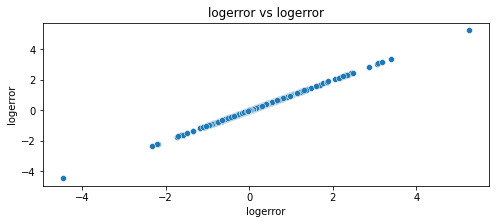

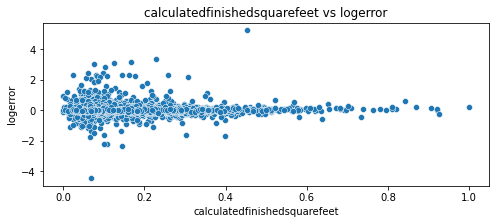

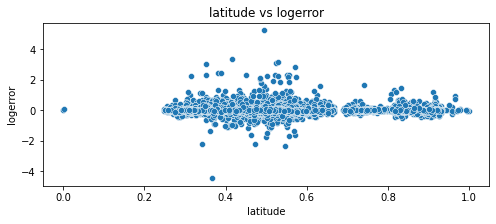

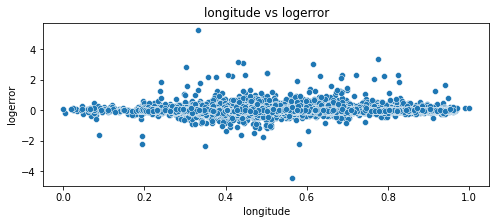

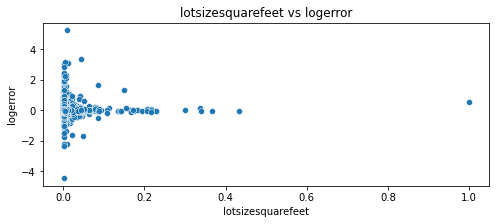

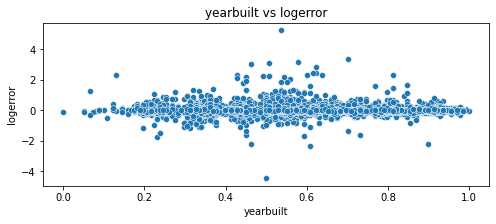

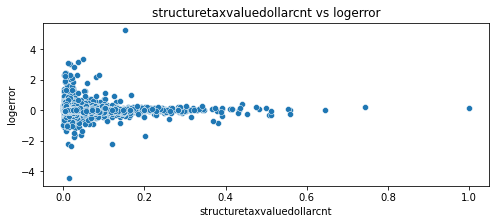

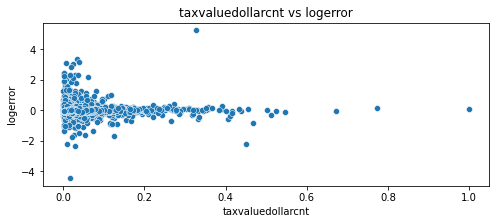

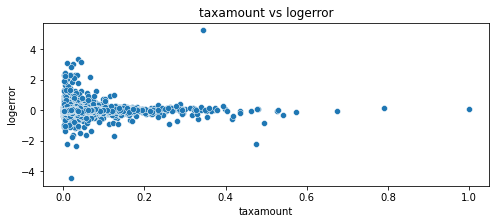

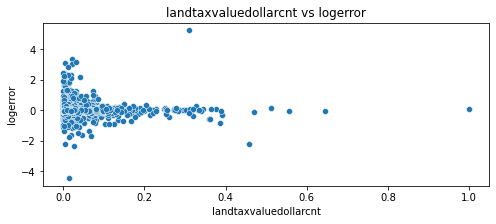

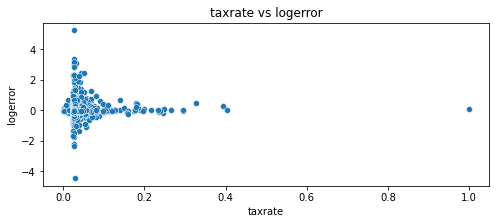

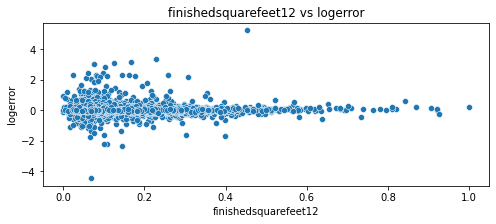

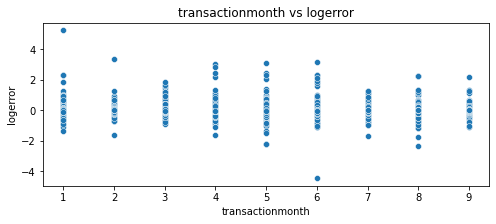

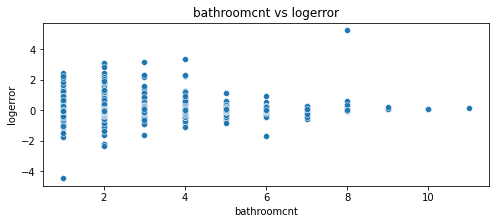

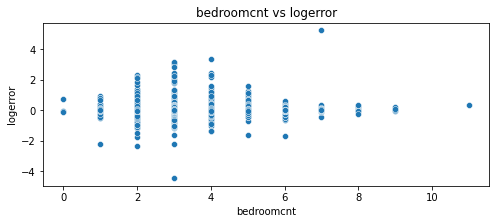

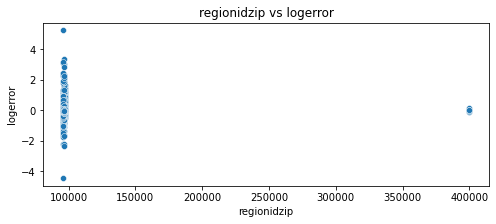

In [14]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, and Age of the house play a big role in Log Error 
- The more houses are similar to eachother in terms of these 3 main topics , the harder it is to predict there price accurately
    * Why? because as it stands, Our dataset doesnt have these vaariables grouped in a meaningful way.
    * latitide and logitude are too unique for the computer to understand how they realate even if the houses were right next to eachother.
     Buit with the help of these 3 main variables, the value of the house 
- we will look more into location vs price vs size , cluster these and see if these types of houses prioritize diffrent drivers for predicting logerror and model to their needs for a possibly better Predicitons

### Price

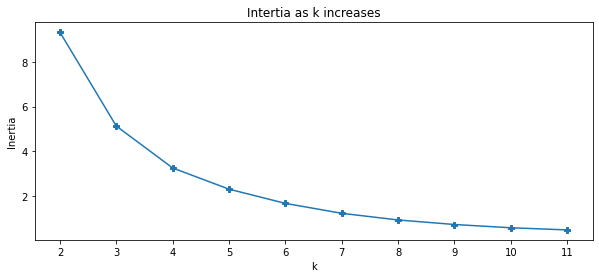

In [15]:
X = train_scaled[['taxvaluedollarcnt']]
cluster.view_intertia(X)

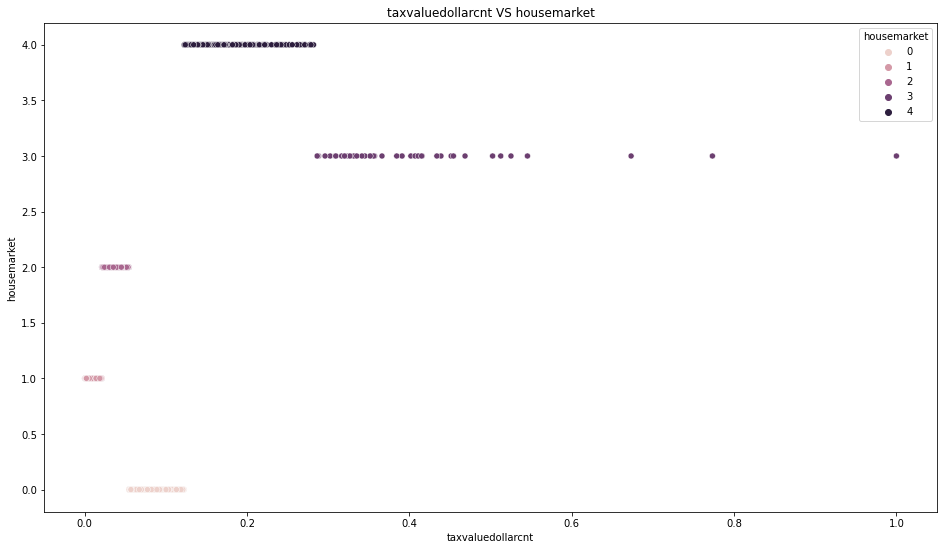

In [16]:
X = cluster.show_cluster(X, 5, 'housemarket')

In [17]:
#Add clusters onto existing training dataset
train_scaled['housemarket'] = X['housemarket']

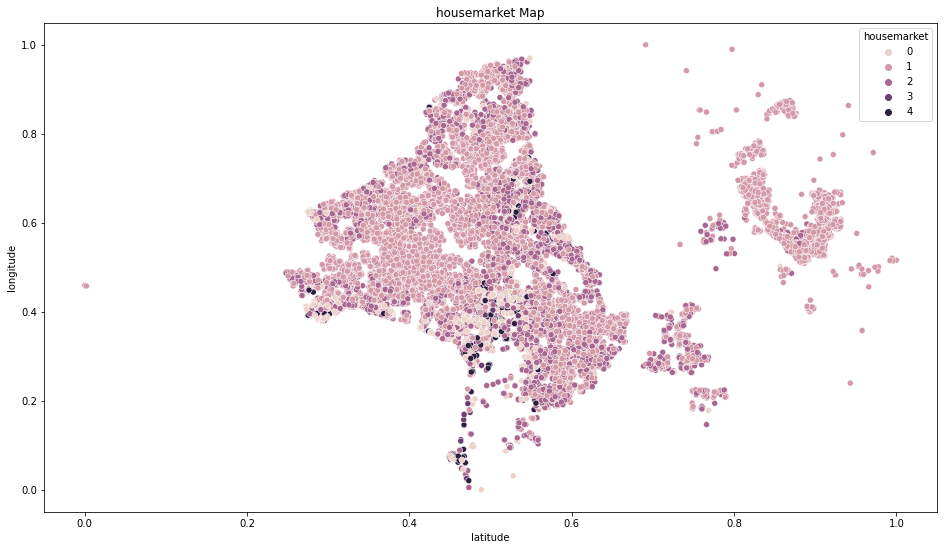

In [18]:
cluster.map_clusters(train_scaled, 'housemarket')

### Size

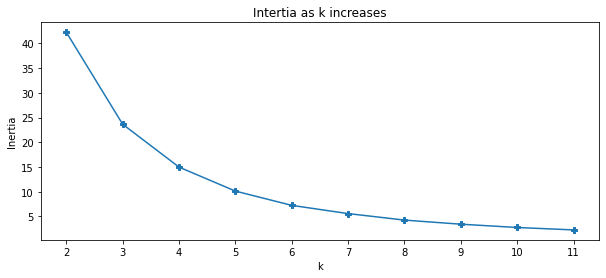

In [19]:
X = train_scaled[['calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

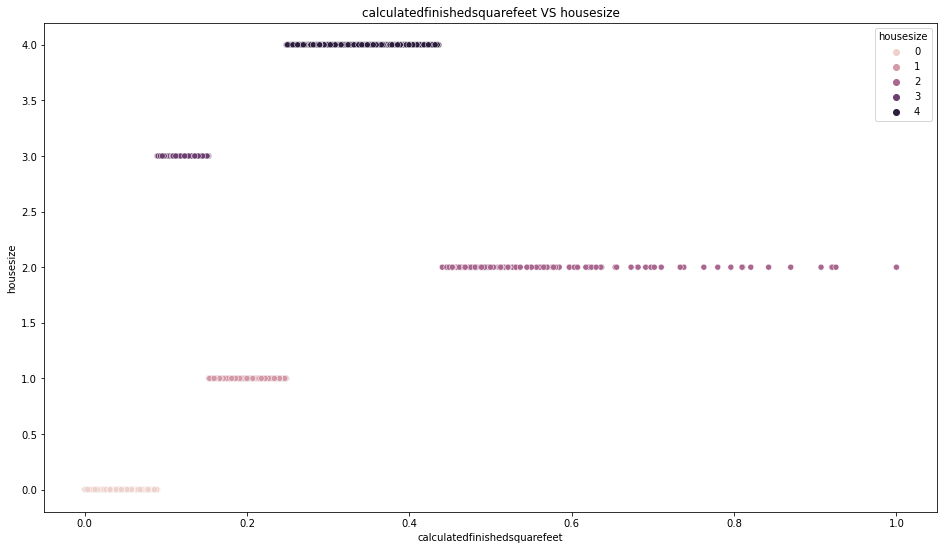

In [20]:
X = cluster.show_cluster(X, 5, 'housesize')

In [21]:
train_scaled['housesize'] = X['housesize']

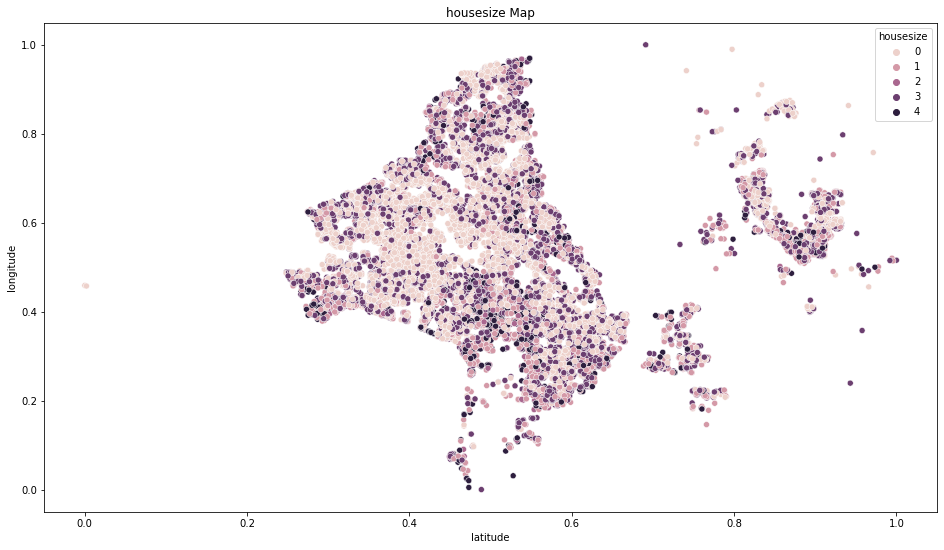

In [22]:
cluster.map_clusters(train_scaled, 'housesize')

### Age

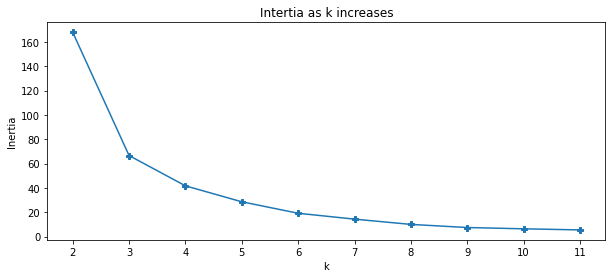

In [23]:
X = train_scaled[['yearbuilt']]
cluster.view_intertia(X)

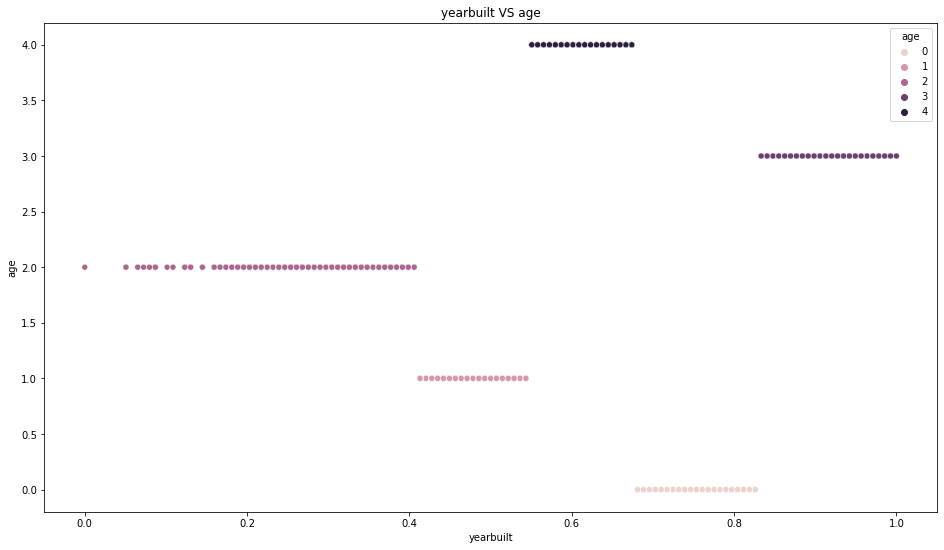

In [24]:
X = cluster.show_cluster(X, 5, 'age')

In [25]:
train_scaled['age'] = X['age']

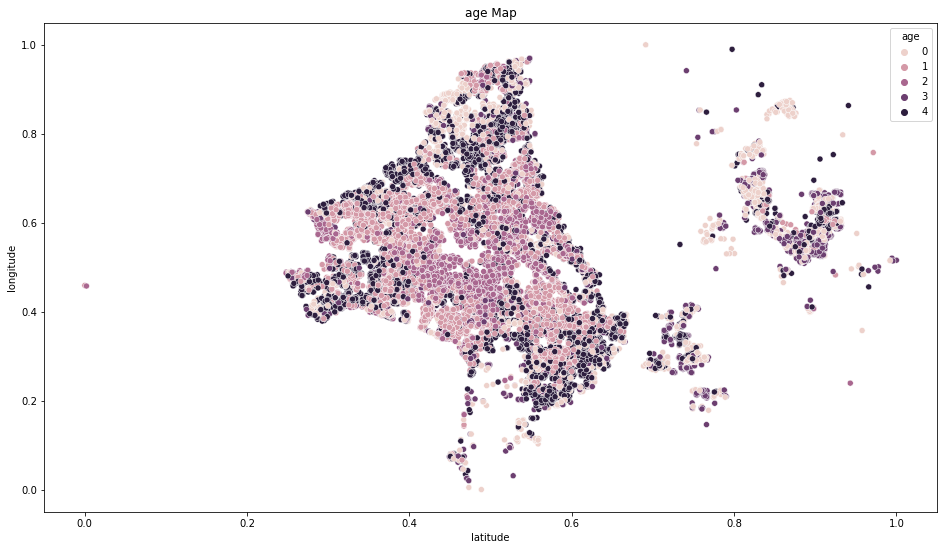

In [26]:
cluster.map_clusters(train_scaled, 'age')

## Cross Referencing our Big 3

### Size vs Price

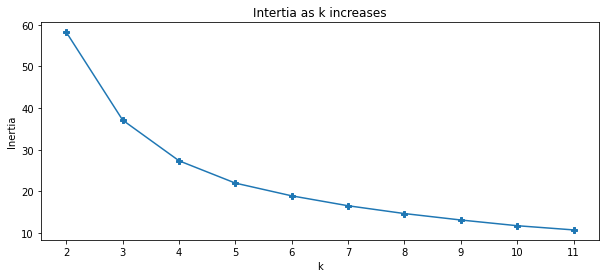

In [27]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
cluster.view_intertia(X)

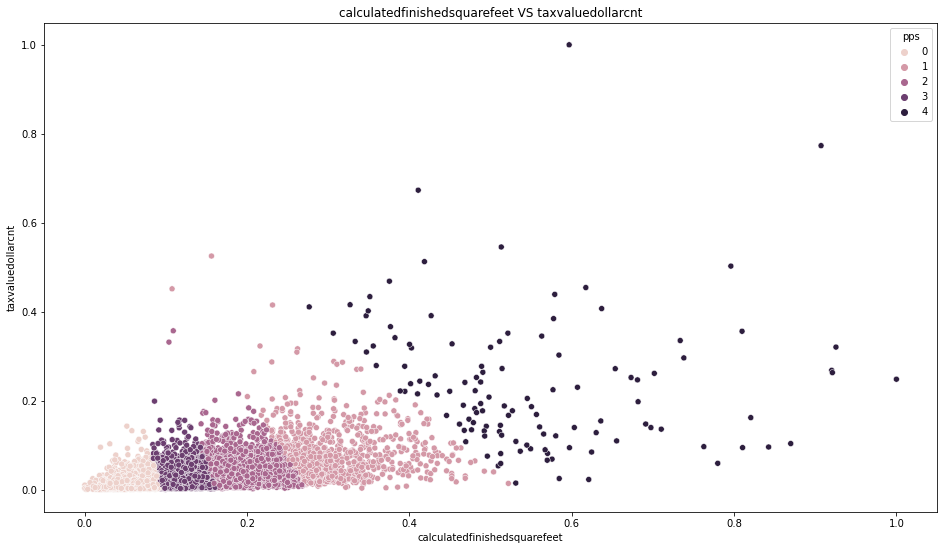

In [28]:
#Price by Size
X = cluster.show_cluster(X, 5, 'pps')

In [29]:
train_scaled['pps'] = X['pps']

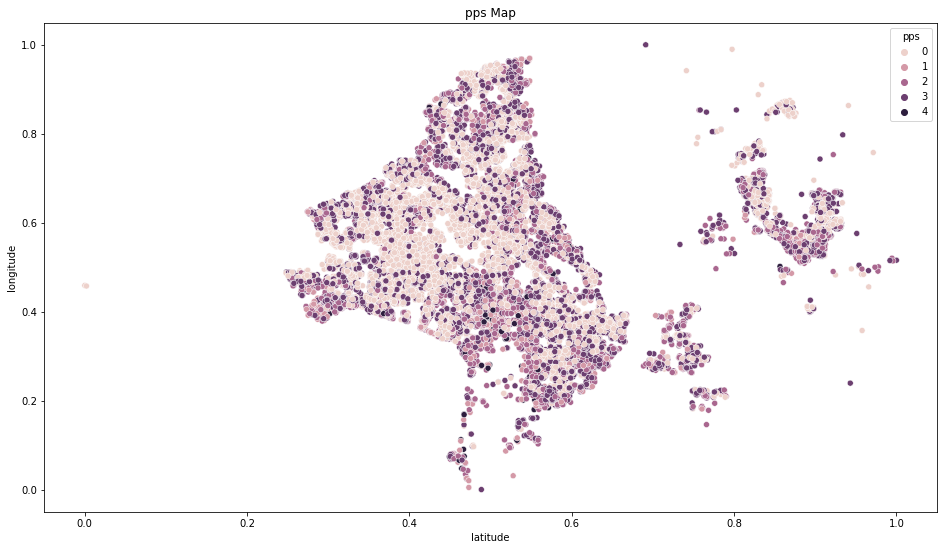

In [30]:
cluster.map_clusters(train_scaled, 'pps')

### Price vs Age

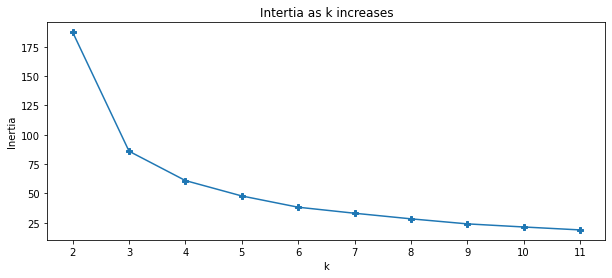

In [31]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

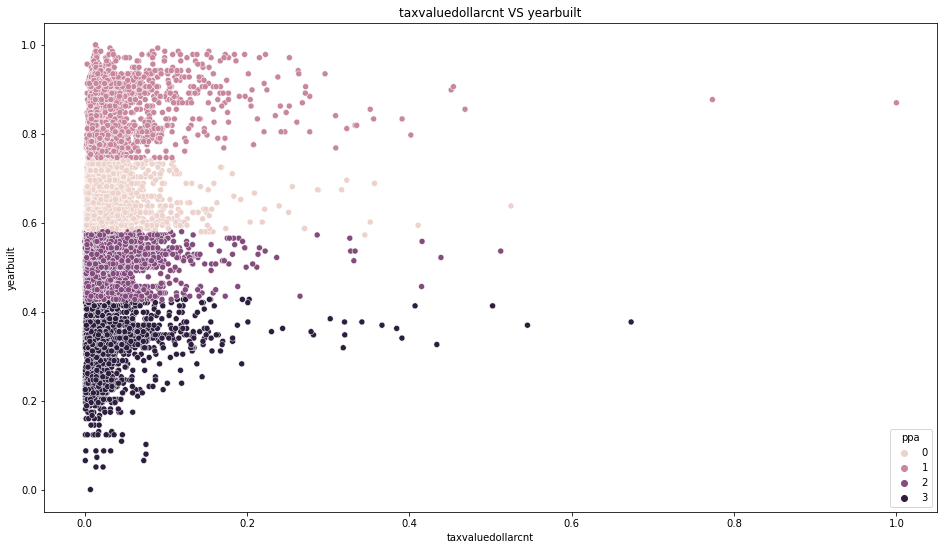

In [32]:
#price per age
X = cluster.show_cluster(X, 4, 'ppa')

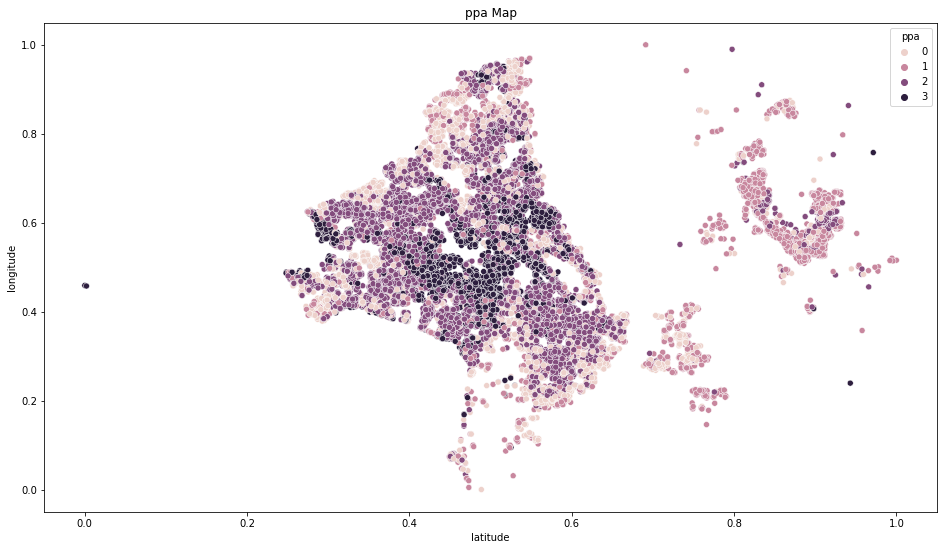

In [33]:
train_scaled['ppa'] = X['ppa']
cluster.map_clusters(train_scaled, 'ppa')

### Age vs Size

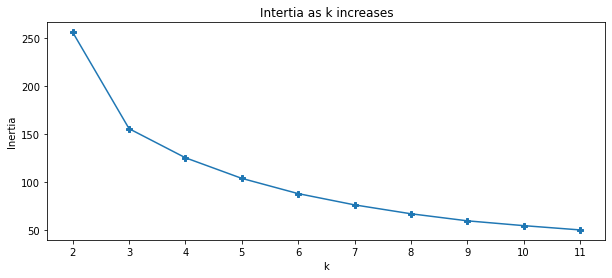

In [34]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
cluster.view_intertia(X)

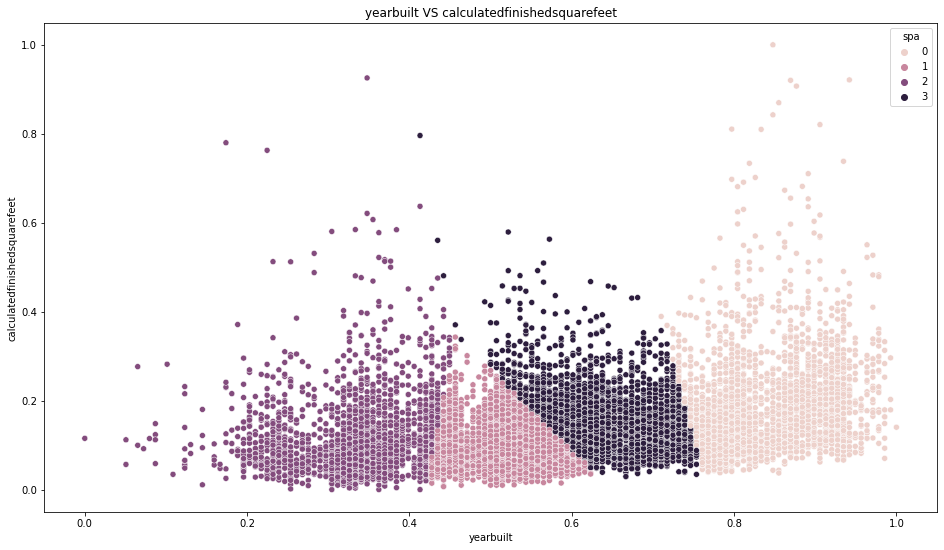

In [35]:
X = cluster.show_cluster(X, 4, 'spa')

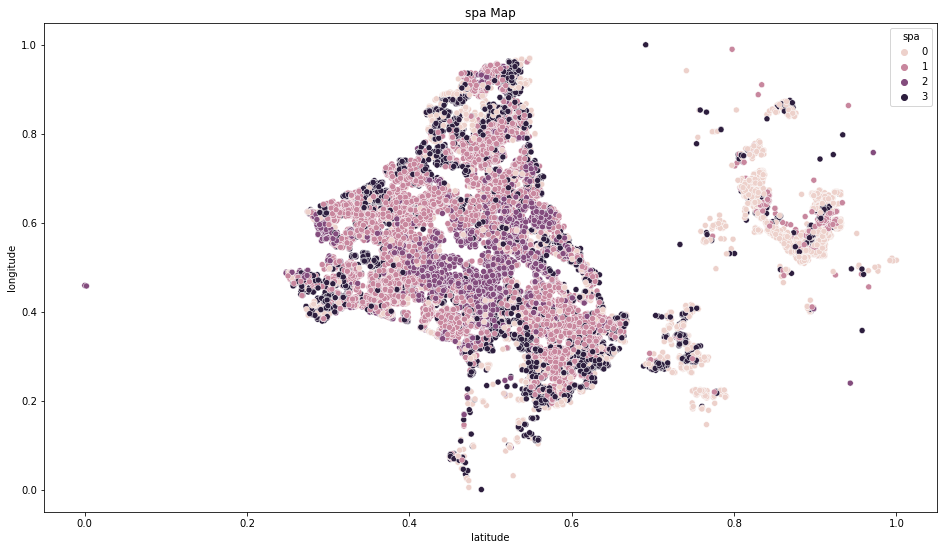

In [36]:
train_scaled['spa'] = X['spa']
cluster.map_clusters(train_scaled, 'spa')

## All 3

### Size vs Price vs Age

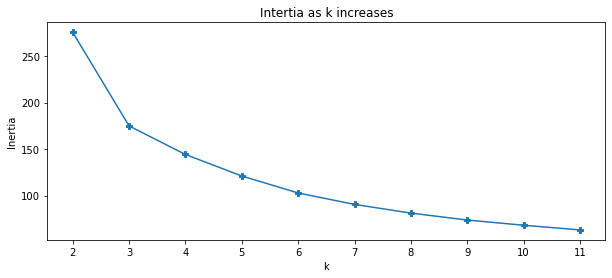

In [37]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
cluster.view_intertia(X)

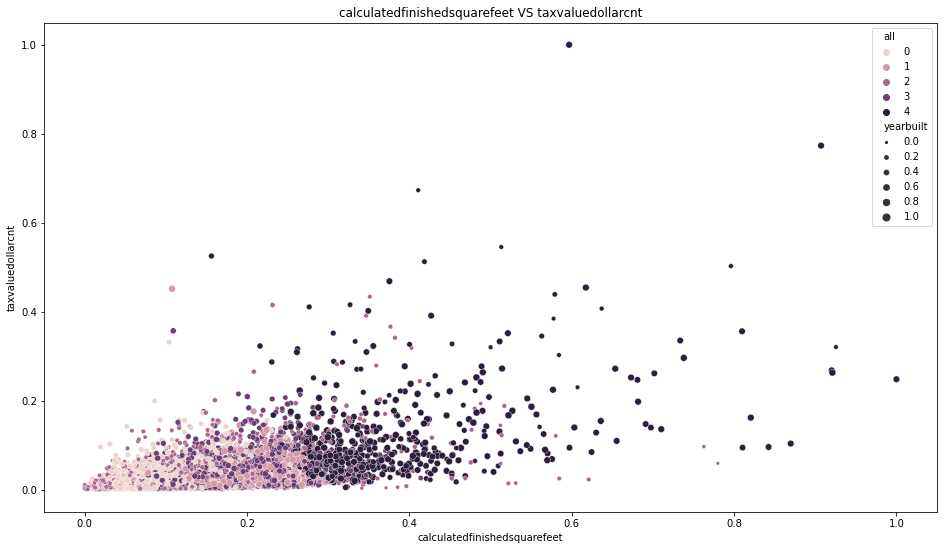

In [38]:
X = cluster.show_cluster(X, 5, 'all', 'yearbuilt')

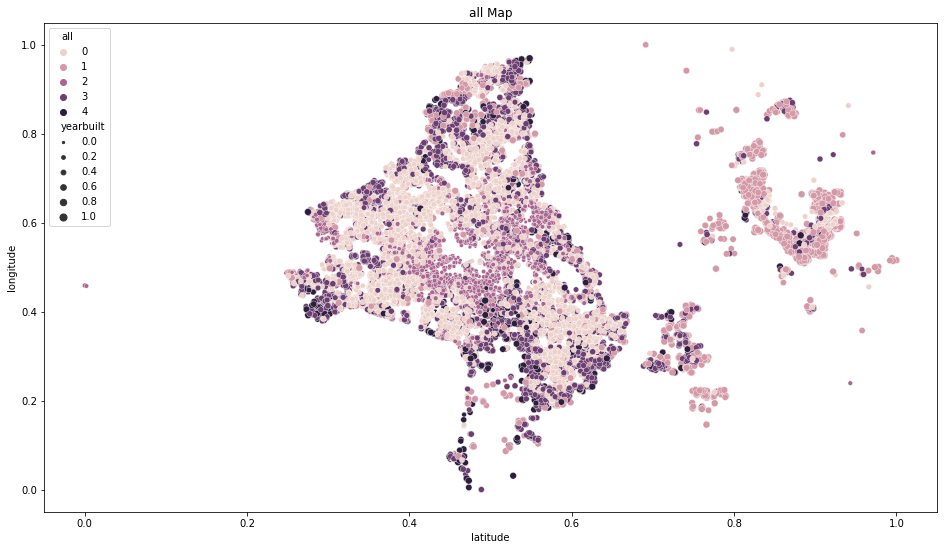

In [39]:
train_scaled['all'] = X['all']
cluster.map_clusters(train_scaled, 'all', 'yearbuilt' )